# This notebook is to prepare the data to be used by the algorithms in order to prevent running all the time

In [1]:
#scipy
import scipy.sparse as sp
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr

#pandas
from pandas import ExcelWriter
from pandas import ExcelFile
import pandas as pd

#numpy
import numpy as np

#ploting
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#sklearn -scaling imputing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


#data balance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#h5py dataset processing
import h5py

#supress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preparation & Exploration

## Read the data

Reads in the weather data and the regions data. The region data states if the location is located in the Northern or Southern part of the country.

It also prepares the season column. This column was made because australia has two main seasons for rain depending on the region

In [2]:
df = pd.read_csv('weatherAUS.csv')
df2 = pd.read_csv('regions.csv')
df['Region'] = 'NaN'
df['Season'] = 'NaN'
for i in range(len(df2.Location)):
    location = df2['Location'][i]
    region = df2['region'][i]
    df.Region[df['Location'] == location] = region

df.drop(['Location'], axis=1, inplace=True)
#Create a season column based on the month of the year
df['Season'][pd.to_datetime(df['Date']).dt.strftime('%B').isin(['April', 'May', 'June', 'July', 'August', 'September'])]= 'April-Sept'
df['Season'][pd.to_datetime(df['Date']).dt.strftime('%B').isin(['October', 'November', 'December', 'January', 'February', 'March'])]= 'Oct-March'

df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Region,Season
0,2008-12-01,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,Southern,Oct-March
1,2008-12-02,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,Southern,Oct-March
2,2008-12-03,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,Southern,Oct-March
3,2008-12-04,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,Southern,Oct-March
4,2008-12-05,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,Southern,Oct-March


rearrange and rename the columns

In [3]:
cols = df.columns.tolist()
cols = cols[0:1] + cols[-2:] + cols[1:-2]
df = df[cols]
df.rename(columns={'Region':'Location'},inplace=True)

In [4]:
df.columns = df.columns.str.strip()
df['RainTomorrow'] = df['RainTomorrow'].map( {'No': 0, 'Yes': 1} ).astype(int)

Just looking at column dataframe datatypes

In [5]:
df.dtypes

Date              object
Location          object
Season            object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow       int32
dtype: object

# Split data into 2 groups

All Data before July 2016 will be used for training while all data from July 2016 will be used to test the models

In [6]:
trainYear = df[df['Date'] < "2016-07-01"]
testYear = df[df['Date'] >= "2016-07-01"]
trainYear = trainYear.to_numpy()
testYear = testYear.to_numpy()
trainYear = pd.DataFrame(trainYear, columns=df.columns)
testYear = pd.DataFrame(testYear, columns=df.columns)
trainYear = trainYear.astype(dtype={'Date': object,'Location':object,'Season':object,'MinTemp': 'float64','MaxTemp':'float64','Rainfall': 'float64','Evaporation':'float64','Sunshine': 'float64','WindGustDir':object,'WindGustSpeed': 'float64','WindDir9am':object,'WindDir3pm': object,'WindSpeed9am':'float64','WindSpeed3pm': 'float64','Humidity9am':'float64','Humidity3pm': 'float64','Pressure9am':'float64','Pressure3pm': 'float64','Cloud9am':'float64','Cloud3pm': 'float64','Temp9am':'float64','Temp3pm': 'float64','RainToday':object,'RISK_MM': 'float64','RainTomorrow':'int32'})
testYear = testYear.astype(dtype={'Date': object,'Location':object,'Season':object,'MinTemp': 'float64','MaxTemp':'float64','Rainfall': 'float64','Evaporation':'float64','Sunshine': 'float64','WindGustDir':object,'WindGustSpeed': 'float64','WindDir9am':object,'WindDir3pm': object,'WindSpeed9am':'float64','WindSpeed3pm': 'float64','Humidity9am':'float64','Humidity3pm': 'float64','Pressure9am':'float64','Pressure3pm': 'float64','Cloud9am':'float64','Cloud3pm': 'float64','Temp9am':'float64','Temp3pm': 'float64','RainToday':object,'RISK_MM': 'float64','RainTomorrow':'int32'})

# Explore Missing Values

Looking at the missing values below, we can see that 40% of the values in the Evaporation, Sunshine, Cloud9am and Cloud3pm variables are missing. Further inspection of the training and test set shows that more than 50% of the values in the test set are missing. Giving that we will impute these variables as scikit doesn't accept missing variables replacing them will replace majority of the data. Hence, these columns will not be used for the model

In [7]:
df.isnull().mean(axis = 0) * 100

Date              0.000000
Location          0.000000
Season            0.000000
MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
RainToday         0.988797
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64

In [8]:
trainYear.isnull().mean(axis = 0) * 100

Date              0.000000
Location          0.000000
Season            0.000000
MinTemp           0.415509
MaxTemp           0.210557
Rainfall          0.971923
Evaporation      40.110642
Sunshine         44.114421
WindGustDir       6.680971
WindGustSpeed     6.632935
WindDir9am        7.216569
WindDir3pm        2.374567
WindSpeed9am      1.013554
WindSpeed3pm      1.515528
Humidity9am       1.234518
Humidity3pm       1.930236
Pressure9am       9.796088
Pressure3pm       9.767267
Cloud9am         36.708911
Cloud3pm         38.370147
Temp9am           0.678905
Temp3pm           1.346602
RainToday         0.971923
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64

In [9]:
testYear.isnull().mean(axis = 0) * 100

Date              0.000000
Location          0.000000
Season            0.000000
MinTemp           0.682633
MaxTemp           0.341317
Rainfall          1.110725
Evaporation      62.142774
Sunshine         73.550850
WindGustDir       5.698253
WindGustSpeed     5.698253
WindDir9am        5.779243
WindDir3pm        4.697443
WindSpeed9am      0.474372
WindSpeed3pm      4.263566
Humidity9am       1.342127
Humidity3pm       6.936249
Pressure9am      10.285780
Pressure3pm      10.303135
Cloud9am         45.152146
Cloud3pm         53.031355
Temp9am           0.323962
Temp3pm           6.039570
RainToday         1.110725
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64

Evaporation, Sunshine, Cloud 9am & 3pm were dropped due to the % of missing values. As replacing such a large number of missing values makes no sense in leaving the featyres.

Risk_mm was removed as it was recommended by the owner of the dataset as it kind of leaks the answer to the model and gives a false sense of good performance by the models.

In [10]:
trainYear.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm','RISK_MM'], axis=1, inplace=True)
testYear.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm','RISK_MM'], axis=1, inplace=True)

## Correlation Matrix

The correlation matrix for the training data was reviewed to observe highly correlated features.

In [11]:
trainYear.corr()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainTomorrow
MinTemp,1.000000,0.735048,0.104338,0.178734,0.177856,0.177005,-0.233673,0.008107,-0.447661,-0.457217,0.901281,0.708224,0.084140
MaxTemp,0.735048,1.000000,-0.073479,0.068704,0.015470,0.050694,-0.506784,-0.508762,-0.327274,-0.421548,0.886462,0.984689,-0.161141
Rainfall,0.104338,-0.073479,1.000000,0.131602,0.084941,0.055560,0.222593,0.253426,-0.168424,-0.128262,0.012625,-0.076880,0.238596
WindGustSpeed,0.178734,0.068704,0.131602,1.000000,0.605117,0.685232,-0.217565,-0.029475,-0.450956,-0.406389,0.151930,0.034161,0.230033
WindSpeed9am,0.177856,0.015470,0.084941,0.605117,1.000000,0.520129,-0.272990,-0.034096,-0.221240,-0.169305,0.130692,0.005146,0.087724
WindSpeed3pm,0.177005,0.050694,0.055560,0.685232,0.520129,1.000000,-0.147868,0.014080,-0.290825,-0.250040,0.164458,0.027374,0.083862
Humidity9am,-0.233673,-0.506784,0.222593,-0.217565,-0.272990,-0.147868,1.000000,0.667699,0.131695,0.179757,-0.473473,-0.500176,0.261002
Humidity3pm,0.008107,-0.508762,0.253426,-0.029475,-0.034096,0.014080,0.667699,1.000000,-0.031978,0.048068,-0.219845,-0.557401,0.447910
Pressure9am,-0.447661,-0.327274,-0.168424,-0.450956,-0.221240,-0.290825,0.131695,-0.031978,1.000000,0.961533,-0.418205,-0.284368,-0.244211
Pressure3pm,-0.457217,-0.421548,-0.128262,-0.406389,-0.169305,-0.250040,0.179757,0.048068,0.961533,1.000000,-0.464868,-0.386758,-0.222807


Temp 9am and Min Temp, Temp 3am and Max Temp, Pressure 9am and 3pm are Highly correlated i.e. correlation greater than .8. SO spearmans r was used to check the significance of the correlation.

In [12]:
print('Temp 9am and Min Temp')
print(spearmanr(trainYear.Temp9am,trainYear.MinTemp, nan_policy='omit'))

print('Temp 3pm and Max Temp')
print(spearmanr(trainYear.Temp3pm,trainYear.MaxTemp, nan_policy='omit'))

print('Pressure 9am and Pressure 3pm')
print(spearmanr(trainYear.Pressure9am,trainYear.Pressure3pm, nan_policy='omit'))

print('Max Temp and Min Temp')
print(spearmanr(trainYear.MaxTemp,trainYear.MinTemp, nan_policy='omit'))

Temp 9am and Min Temp
SpearmanrResult(correlation=0.898699172124491, pvalue=0.0)
Temp 3pm and Max Temp
SpearmanrResult(correlation=0.9845692406688484, pvalue=0.0)
Pressure 9am and Pressure 3pm
SpearmanrResult(correlation=0.9595591064714105, pvalue=0.0)
Max Temp and Min Temp
SpearmanrResult(correlation=0.7372009790086542, pvalue=0.0)


## Drop Temp 9am & 3pm and Pressure 9am due to high collinearity issues

In order to restrict multicollinearity in the features temperature 9am, 3pm and pressure 9am were dropped. Pressure 9am was droped bevause Pressure 3pm gives the latest pressure reading. So why keep the old one? Also, Pressure3pm had marginally less missing data.

In [13]:
trainYear.drop(['Pressure9am','Temp9am','Temp3pm'], axis=1, inplace=True)
testYear.drop(['Pressure9am','Temp9am','Temp3pm'], axis=1, inplace=True)

In [14]:
trainYear.corr()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,RainTomorrow
MinTemp,1.000000,0.735048,0.104338,0.178734,0.177856,0.177005,-0.233673,0.008107,-0.457217,0.084140
MaxTemp,0.735048,1.000000,-0.073479,0.068704,0.015470,0.050694,-0.506784,-0.508762,-0.421548,-0.161141
Rainfall,0.104338,-0.073479,1.000000,0.131602,0.084941,0.055560,0.222593,0.253426,-0.128262,0.238596
WindGustSpeed,0.178734,0.068704,0.131602,1.000000,0.605117,0.685232,-0.217565,-0.029475,-0.406389,0.230033
WindSpeed9am,0.177856,0.015470,0.084941,0.605117,1.000000,0.520129,-0.272990,-0.034096,-0.169305,0.087724
WindSpeed3pm,0.177005,0.050694,0.055560,0.685232,0.520129,1.000000,-0.147868,0.014080,-0.250040,0.083862
Humidity9am,-0.233673,-0.506784,0.222593,-0.217565,-0.272990,-0.147868,1.000000,0.667699,0.179757,0.261002
Humidity3pm,0.008107,-0.508762,0.253426,-0.029475,-0.034096,0.014080,0.667699,1.000000,0.048068,0.447910
Pressure3pm,-0.457217,-0.421548,-0.128262,-0.406389,-0.169305,-0.250040,0.179757,0.048068,1.000000,-0.222807
RainTomorrow,0.084140,-0.161141,0.238596,0.230033,0.087724,0.083862,0.261002,0.447910,-0.222807,1.000000


From the correlation chart above the remaining features have no really high correlated features left

## Outliers 

In [15]:
trainYearO = trainYear.copy()
trainYearO.head()

,Date,Location,Season,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,RainToday,RainTomorrow
0,2008-12-01,Southern,Oct-March,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.1,No,0
1,2008-12-02,Southern,Oct-March,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1007.8,No,0
2,2008-12-03,Southern,Oct-March,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1008.7,No,0
3,2008-12-04,Southern,Oct-March,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1012.8,No,0
4,2008-12-05,Southern,Oct-March,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1006.0,No,0


In [16]:
trainYearO.drop(['Date','Location','Season','WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow'], axis=1, inplace=True)
cols = list(trainYearO.columns)

In [17]:
print(cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm']


In [18]:
for col in cols:
    col_zscore = col + '_zscore'
    trainYearO[col_zscore] = (trainYearO[col] - trainYearO[col].mean())/trainYearO[col].std(ddof=0)

In [19]:
trainYearO.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm'], axis=1, inplace=True)

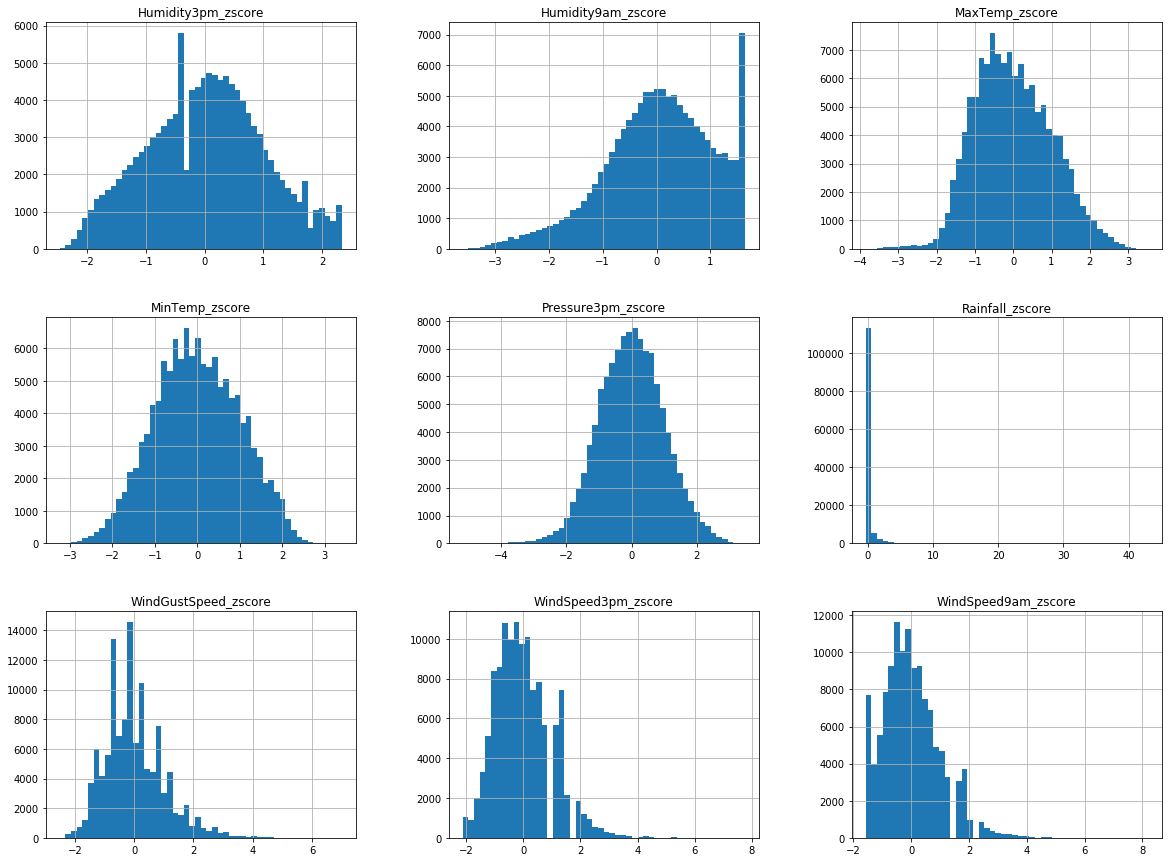

In [20]:
trainYearO.hist(bins=50,figsize=(20,15))
plt.show()

In [21]:
(trainYearO < -2.0).mean(axis = 0) * 100

MinTemp_zscore          1.906218
MaxTemp_zscore          0.983131
Rainfall_zscore         0.000000
WindGustSpeed_zscore    0.212158
WindSpeed9am_zscore     0.000000
WindSpeed3pm_zscore     0.817408
Humidity9am_zscore      3.853267
Humidity3pm_zscore      1.364215
Pressure3pm_zscore      1.865388
dtype: float64

In [22]:
(trainYearO > 2.0).mean(axis = 0) * 100

MinTemp_zscore          1.775721
MaxTemp_zscore          2.819698
Rainfall_zscore         2.902960
WindGustSpeed_zscore    3.761198
WindSpeed9am_zscore     3.089499
WindSpeed3pm_zscore     3.460174
Humidity9am_zscore      0.000000
Humidity3pm_zscore      2.249674
Pressure3pm_zscore      2.137590
dtype: float64

Looking at the data, it shows more than 95% of the standardized scores fall withim -/+2, I will not be removing outliers and accept the data to be within normality for this experiment.

# Feature Selection, Transformation & Engineering

Unfortunately, I didn't have a weather specialist to rate my decisions on feature engineering, So instead, I will reduce the cardinality of the Cardinal points by assigning the intercardinal points to the respective points of North, South, East or West. I removed the RainToday column as I concluded the Rainfall column was satisfactory which I will visualise below.

The continous features were Normalized to a range of 0 to 1. This ensure each continous feature is on the same scale, as no information has been given on a particular feature being more important.

Missing data for continous features were imputed using the mean, while categorical features were imputed using the mode.

## Rain Today Feature

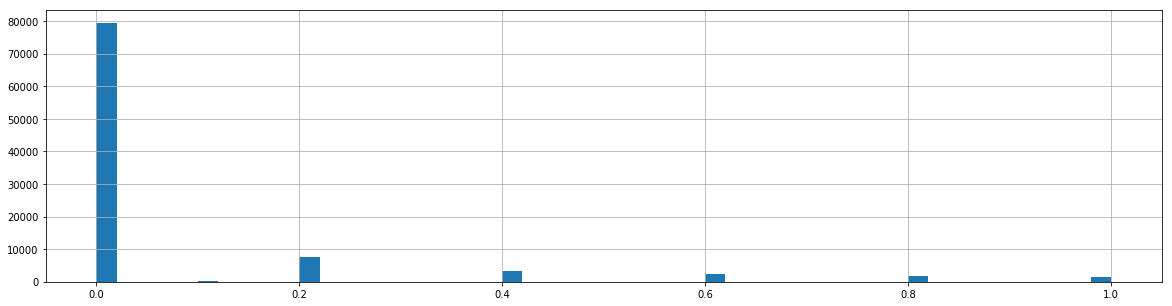

Maximum Rainfall when RainToday is No:  1.0


In [23]:
trainYear['Rainfall'][trainYear['RainToday']=='No'].hist(bins=50,figsize=(20,5))
plt.show()
print('Maximum Rainfall when RainToday is No: ',trainYear['Rainfall'][trainYear['RainToday']=='No'].max())

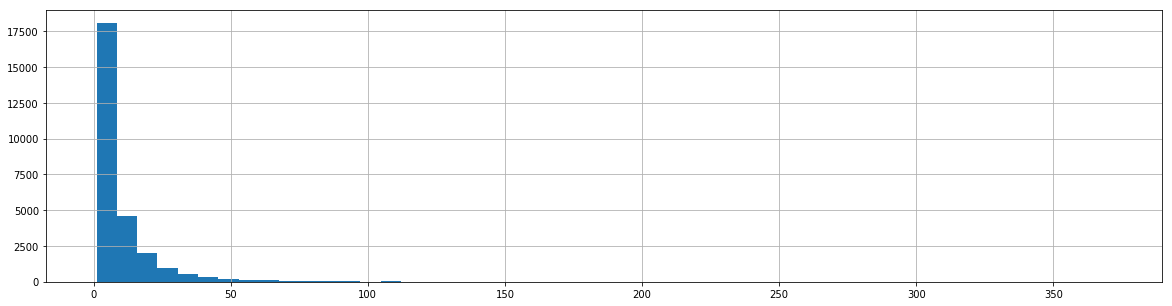

Minimum Rainfall when RainToday is Yes:  1.1


In [24]:
trainYear['Rainfall'][trainYear['RainToday']=='Yes'].hist(bins=50,figsize=(20,5))
plt.show()
print('Minimum Rainfall when RainToday is Yes: ',trainYear['Rainfall'][trainYear['RainToday']=='Yes'].min())

Both also have equal proportions of Missing Data

In [25]:
print(trainYear[['Rainfall','RainToday']].isnull().mean(axis = 0) * 100)
print(testYear[['Rainfall','RainToday']].isnull().mean(axis = 0) * 100)

Rainfall     0.971923
RainToday    0.971923
dtype: float64
Rainfall     1.110725
RainToday    1.110725
dtype: float64


So these two features are very much the same only one is continous and the other is categorical.. Based on that, I'm removing the categorical RainToday feature in favour of the continous feature rainfall

In [26]:
trainYear.drop(['RainToday'], axis=1, inplace=True)
testYear.drop(['RainToday'], axis=1, inplace=True)

## Use sklearns scaler function to scale the continous features

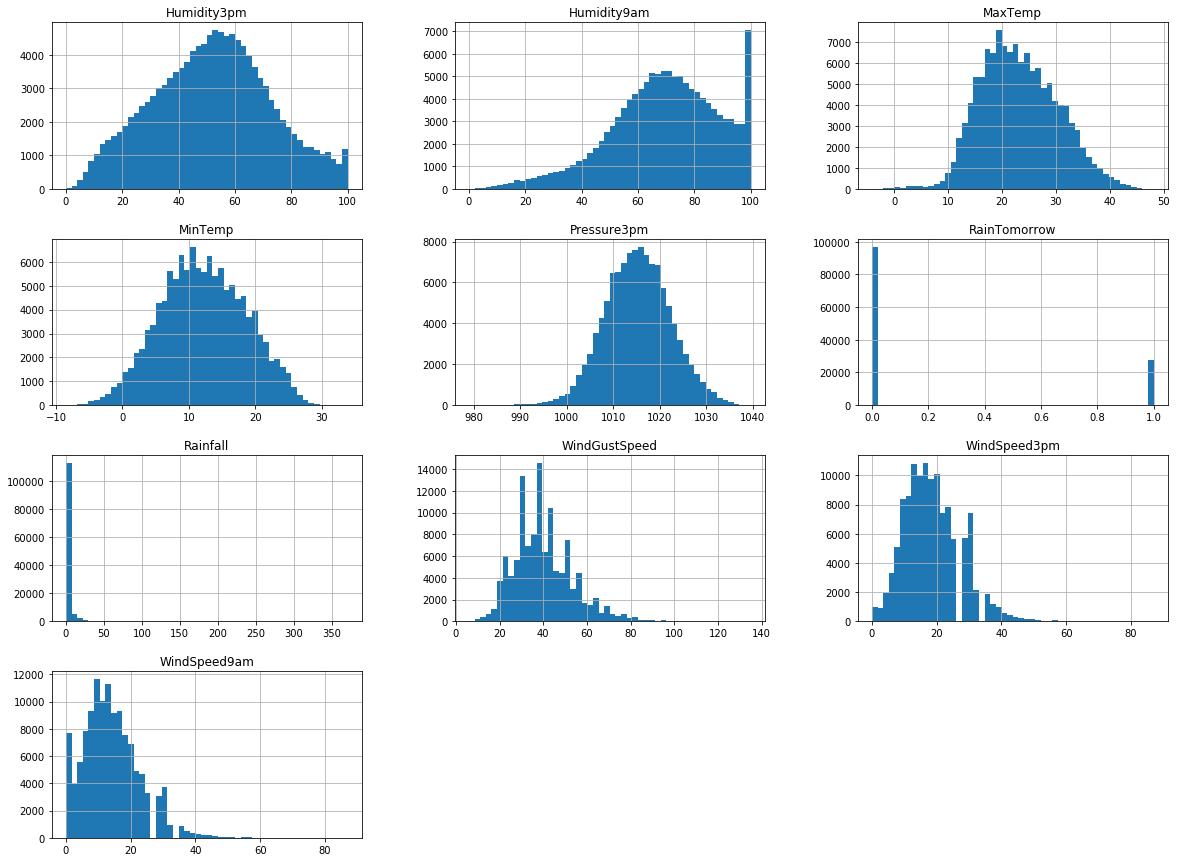

In [27]:
trainYear.hist(bins=50,figsize=(20,15))
plt.show()

The continous features have varying measures and I felt scaling them would improve the performance of the models.

MinMaxScaler was used to Normalize all features to a scale of 0 to 1. This will ensure all features are on the same scale and non can exert greater influence due to a difference in scale.

In [28]:
scaler_Humidity9am = MinMaxScaler()
scaler_Humidity9am.fit(trainYear.Humidity9am.to_numpy().reshape(-1,1))

scaler_Humidity3pm = MinMaxScaler()
scaler_Humidity3pm.fit(trainYear.Humidity3pm.to_numpy().reshape(-1,1))

scaler_WindSpeed9am = MinMaxScaler()
scaler_WindSpeed9am.fit(trainYear.WindSpeed9am.to_numpy().reshape(-1,1))

scaler_WindSpeed3pm = MinMaxScaler()
scaler_WindSpeed3pm.fit(trainYear.WindSpeed3pm.to_numpy().reshape(-1,1))

scaler_WindGustSpeed = MinMaxScaler()
scaler_WindGustSpeed.fit(trainYear.WindGustSpeed.to_numpy().reshape(-1,1))

scaler_Rainfall = MinMaxScaler()
scaler_Rainfall.fit(trainYear.Rainfall.to_numpy().reshape(-1,1))

scaler_MaxTemp = MinMaxScaler()
scaler_MaxTemp.fit(trainYear.MaxTemp.to_numpy().reshape(-1,1))

scaler_MinTemp = MinMaxScaler()
scaler_MinTemp.fit(trainYear.MinTemp.to_numpy().reshape(-1,1))

scaler_Pressure3pm = MinMaxScaler()
scaler_Pressure3pm.fit(trainYear.Pressure3pm.to_numpy().reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [29]:
scaled_Humidity9am = scaler_Humidity9am.transform(trainYear.Humidity9am.to_numpy().reshape(-1,1))
scaled_Humidity3pm = scaler_Humidity3pm.transform(trainYear.Humidity3pm.to_numpy().reshape(-1,1))
scaled_WindSpeed9am = scaler_WindSpeed9am.transform(trainYear.WindSpeed9am.to_numpy().reshape(-1,1))
scaled_WindSpeed3pm = scaler_WindSpeed3pm.transform(trainYear.WindSpeed3pm.to_numpy().reshape(-1,1))
scaled_WindGustSpeed = scaler_WindGustSpeed.transform(trainYear.WindGustSpeed.to_numpy().reshape(-1,1))
scaled_Rainfall = scaler_Rainfall.transform(trainYear.Rainfall.to_numpy().reshape(-1,1))
scaled_MaxTemp = scaler_MaxTemp.transform(trainYear.MaxTemp.to_numpy().reshape(-1,1))
scaled_minTemp = scaler_MinTemp.transform(trainYear.MinTemp.to_numpy().reshape(-1,1))
scaled_Pressure3pm = scaler_Pressure3pm.transform(trainYear.Pressure3pm.to_numpy().reshape(-1,1))

In [30]:
trainYear.Humidity9am = scaled_Humidity9am
trainYear.Humidity3pm = scaled_Humidity3pm
trainYear.WindSpeed9am = scaled_WindSpeed9am
trainYear.WindSpeed3pm = scaled_WindSpeed3pm
trainYear.WindGustSpeed = scaled_WindGustSpeed
trainYear.Rainfall = scaled_Rainfall
trainYear.MaxTemp = scaled_MaxTemp
trainYear.MinTemp = scaled_minTemp
trainYear.Pressure3pm = scaled_Pressure3pm

# Scale the test set based on the train set

In [31]:
test_scaled_Humidity9am = scaler_Humidity9am.transform(testYear.Humidity9am.to_numpy().reshape(-1,1))
test_scaled_Humidity3pm = scaler_Humidity3pm.transform(testYear.Humidity3pm.to_numpy().reshape(-1,1))
test_scaled_WindSpeed9am = scaler_WindSpeed9am.transform(testYear.WindSpeed9am.to_numpy().reshape(-1,1))
test_scaled_WindSpeed3pm = scaler_WindSpeed3pm.transform(testYear.WindSpeed3pm.to_numpy().reshape(-1,1))
test_scaled_WindGustSpeed = scaler_WindGustSpeed.transform(testYear.WindGustSpeed.to_numpy().reshape(-1,1))
test_scaled_Rainfall = scaler_Rainfall.transform(testYear.Rainfall.to_numpy().reshape(-1,1))
test_scaled_MaxTemp = scaler_MaxTemp.transform(testYear.MaxTemp.to_numpy().reshape(-1,1))
test_scaled_minTemp = scaler_MinTemp.transform(testYear.MinTemp.to_numpy().reshape(-1,1))
test_scaled_Pressure3pm = scaler_MaxTemp.transform(testYear.Pressure3pm.to_numpy().reshape(-1,1))

In [32]:
testYear.Humidity9am = test_scaled_Humidity9am
testYear.Humidity3pm = test_scaled_Humidity3pm
testYear.WindSpeed9am = test_scaled_WindSpeed9am
testYear.WindSpeed3pm = test_scaled_WindSpeed3pm
testYear.WindGustSpeed = test_scaled_WindGustSpeed
testYear.Rainfall = test_scaled_Rainfall
testYear.MaxTemp = test_scaled_MaxTemp
testYear.MinTemp = test_scaled_minTemp
testYear.Pressure3pm = test_scaled_Pressure3pm

# Use sklearns imputer function to impute the missing categorical values based on mode

In [33]:
trainYear.isnull().mean(axis = 0) * 100

Date             0.000000
Location         0.000000
Season           0.000000
MinTemp          0.415509
MaxTemp          0.210557
Rainfall         0.971923
WindGustDir      6.680971
WindGustSpeed    6.632935
WindDir9am       7.216569
WindDir3pm       2.374567
WindSpeed9am     1.013554
WindSpeed3pm     1.515528
Humidity9am      1.234518
Humidity3pm      1.930236
Pressure3pm      9.767267
RainTomorrow     0.000000
dtype: float64

In [34]:
testYear.isnull().mean(axis = 0) * 100

Date              0.000000
Location          0.000000
Season            0.000000
MinTemp           0.682633
MaxTemp           0.341317
Rainfall          1.110725
WindGustDir       5.698253
WindGustSpeed     5.698253
WindDir9am        5.779243
WindDir3pm        4.697443
WindSpeed9am      0.474372
WindSpeed3pm      4.263566
Humidity9am       1.342127
Humidity3pm       6.936249
Pressure3pm      10.303135
RainTomorrow      0.000000
dtype: float64

In [35]:
imp_gustDir = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_gustDir.fit(trainYear.WindGustDir.to_numpy().reshape(-1,1))

imp_Dir3pm = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_Dir3pm.fit(trainYear.WindDir3pm.to_numpy().reshape(-1,1))

imp_Dir9am = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_Dir9am.fit(trainYear.WindDir9am.to_numpy().reshape(-1,1))

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)

In [36]:
#Impute train data
gustDir = imp_gustDir.transform(trainYear.WindGustDir.to_numpy().reshape(-1,1))
Dir3pm = imp_Dir3pm.transform(trainYear.WindDir3pm.to_numpy().reshape(-1,1))
Dir9am = imp_Dir9am.transform(trainYear.WindDir9am.to_numpy().reshape(-1,1))

#Impute test data based on train data
test_gustDir = imp_gustDir.transform(testYear.WindGustDir.to_numpy().reshape(-1,1))
test_Dir3pm = imp_Dir3pm.transform(testYear.WindDir3pm.to_numpy().reshape(-1,1))
test_Dir9am = imp_Dir9am.transform(testYear.WindDir9am.to_numpy().reshape(-1,1))

In [37]:
trainYear.WindGustDir = gustDir
trainYear.WindDir3pm = Dir3pm
trainYear.WindDir9am = Dir9am

testYear.WindGustDir = test_gustDir
testYear.WindDir3pm = test_Dir3pm
testYear.WindDir9am = test_Dir9am

# Cardinal Point

The Cardinal categories are reduced to North South East & West. They can't be treated as continous features and using them as is with dummy variables with the number of instances wouldn't benefit the models, as there are the categorical cardinal point features each with 18 cardinal points. encoding that would mean atleast 33 new features. Also, I have not found any resource stating the intercardinal value has a great effect in determining if it will rain

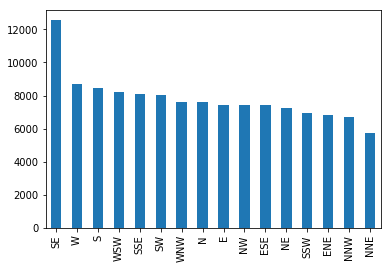

In [38]:
trainYear['WindDir3pm'].value_counts().plot(kind='bar')

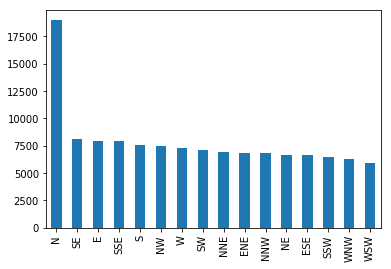

In [39]:
trainYear['WindDir9am'].value_counts().plot(kind='bar')

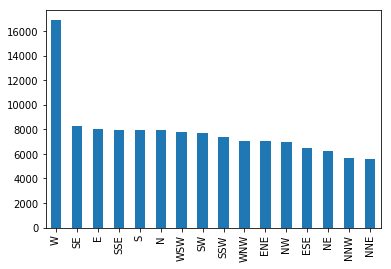

In [40]:
trainYear['WindGustDir'].value_counts().plot(kind='bar')

# Reduce Cardinal Points to N, S, E & W

In [41]:
trainYear['WindGustDir'] = trainYear['WindGustDir'].astype(str).str[0]
trainYear['WindDir3pm'] = trainYear['WindDir3pm'].astype(str).str[0]
trainYear['WindDir9am'] = trainYear['WindDir9am'].astype(str).str[0]

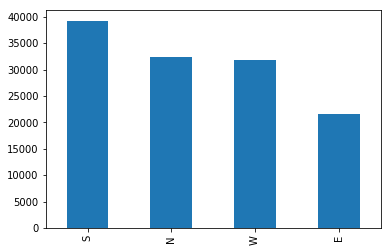

In [42]:
trainYear['WindGustDir'].value_counts().plot(kind='bar')

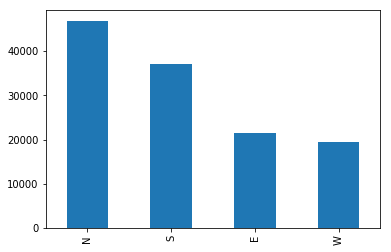

In [43]:
trainYear['WindDir9am'].value_counts().plot(kind='bar')

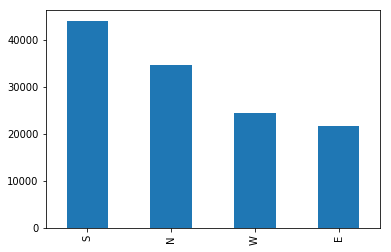

In [44]:
trainYear['WindDir3pm'].value_counts().plot(kind='bar')

In [45]:
testYear['WindGustDir'] = testYear['WindGustDir'].astype(str).str[0]
testYear['WindDir3pm'] = testYear['WindDir3pm'].astype(str).str[0]
testYear['WindDir9am'] = testYear['WindDir9am'].astype(str).str[0]

# Impute Continous Feature

In [46]:
imp_Humidity9am = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_Humidity9am.fit(trainYear.Humidity9am.to_numpy().reshape(-1,1))

imp_Humidity3pm = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_Humidity3pm.fit(trainYear.Humidity3pm.to_numpy().reshape(-1,1))

imp_WindSpeed9am = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_WindSpeed9am.fit(trainYear.WindSpeed9am.to_numpy().reshape(-1,1))

imp_WindSpeed3pm = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_WindSpeed3pm.fit(trainYear.WindSpeed3pm.to_numpy().reshape(-1,1))

imp_WindGustSpeed = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_WindGustSpeed.fit(trainYear.WindGustSpeed.to_numpy().reshape(-1,1))

imp_Rainfall = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_Rainfall.fit(trainYear.Rainfall.to_numpy().reshape(-1,1))

imp_MaxTemp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_MaxTemp.fit(trainYear.MaxTemp.to_numpy().reshape(-1,1))

imp_MinTemp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_MinTemp.fit(trainYear.MinTemp.to_numpy().reshape(-1,1))

imp_Pressure3pm = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_Pressure3pm.fit(trainYear.Pressure3pm.to_numpy().reshape(-1,1))

SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)

In [47]:
#imputed Traind Data Values
Humidity9am = imp_Humidity9am.transform(trainYear.Humidity9am.to_numpy().reshape(-1,1))
Humidity3pm = imp_Humidity3pm.transform(trainYear.Humidity3pm.to_numpy().reshape(-1,1))
WindSpeed9am = imp_WindSpeed9am.transform(trainYear.WindSpeed9am.to_numpy().reshape(-1,1))
WindSpeed3pm = imp_WindSpeed3pm.transform(trainYear.WindSpeed3pm.to_numpy().reshape(-1,1))
WindGustSpeed = imp_WindGustSpeed.transform(trainYear.WindGustSpeed.to_numpy().reshape(-1,1))
Rainfall = imp_Rainfall.transform(trainYear.Rainfall.to_numpy().reshape(-1,1))
MaxTemp = imp_MaxTemp.transform(trainYear.MaxTemp.to_numpy().reshape(-1,1))
minTemp = imp_MinTemp.transform(trainYear.MinTemp.to_numpy().reshape(-1,1))
press3pm = imp_Pressure3pm.transform(trainYear.Pressure3pm.to_numpy().reshape(-1,1))

#imputed Test Data Values
test_Humidity9am = imp_Humidity9am.transform(testYear.Humidity9am.to_numpy().reshape(-1,1))
test_Humidity3pm = imp_Humidity3pm.transform(testYear.Humidity3pm.to_numpy().reshape(-1,1))
test_WindSpeed9am = imp_WindSpeed9am.transform(testYear.WindSpeed9am.to_numpy().reshape(-1,1))
test_WindSpeed3pm = imp_WindSpeed3pm.transform(testYear.WindSpeed3pm.to_numpy().reshape(-1,1))
test_WindGustSpeed = imp_WindGustSpeed.transform(testYear.WindGustSpeed.to_numpy().reshape(-1,1))
test_Rainfall = imp_Rainfall.transform(testYear.Rainfall.to_numpy().reshape(-1,1))
test_MaxTemp = imp_MaxTemp.transform(testYear.MaxTemp.to_numpy().reshape(-1,1))
test_minTemp = imp_MinTemp.transform(testYear.MinTemp.to_numpy().reshape(-1,1))
test_press3pm = imp_Pressure3pm.transform(testYear.Pressure3pm.to_numpy().reshape(-1,1))

In [48]:
#assign imputed values to train data
trainYear.Humidity9am = Humidity9am
trainYear.Humidity3pm = Humidity3pm
trainYear.WindSpeed9am = WindSpeed9am
trainYear.WindSpeed3pm = WindSpeed3pm
trainYear.WindGustSpeed = WindGustSpeed
trainYear.Rainfall = Rainfall
trainYear.MaxTemp = MaxTemp
trainYear.MinTemp = minTemp
trainYear.Pressure3pm = press3pm

#assign imputed values to test data
testYear.Humidity9am = test_Humidity9am
testYear.Humidity3pm = test_Humidity3pm
testYear.WindSpeed9am = test_WindSpeed9am
testYear.WindSpeed3pm = test_WindSpeed3pm
testYear.WindGustSpeed = test_WindGustSpeed
testYear.Rainfall = test_Rainfall
testYear.MaxTemp = test_MaxTemp
testYear.MinTemp = test_minTemp
testYear.Pressure3pm = test_press3pm

# Missing Data Treated

In [49]:
trainYear.isnull().mean(axis = 0) * 100

Date             0.0
Location         0.0
Season           0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure3pm      0.0
RainTomorrow     0.0
dtype: float64

In [50]:
testYear.isnull().mean(axis = 0) * 100

Date             0.0
Location         0.0
Season           0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure3pm      0.0
RainTomorrow     0.0
dtype: float64

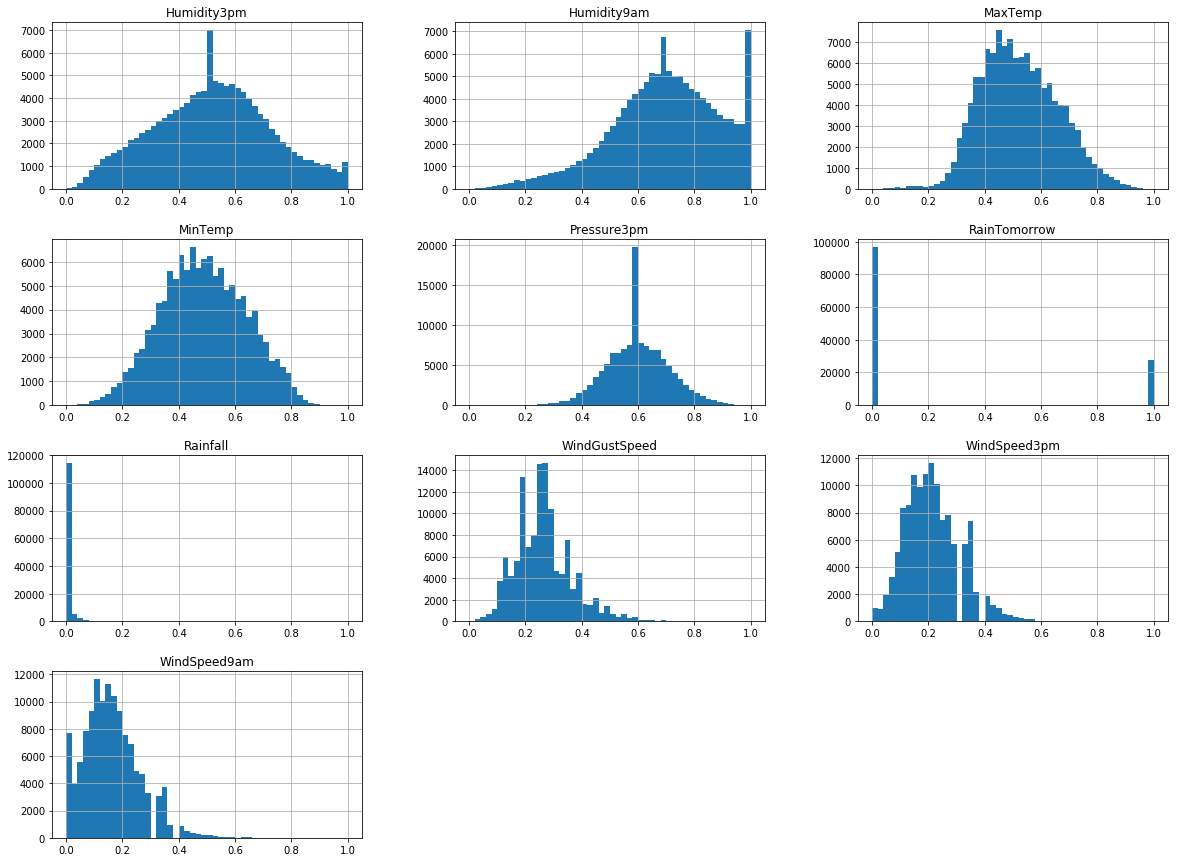

In [51]:
trainYear.hist(bins=50,figsize=(20,15))
plt.show()

# Final Data Prep and Storing

In [52]:
trainYearTarget = trainYear['RainTomorrow']
testYearTarget = testYear['RainTomorrow']
trainYearFeatures = trainYear.drop(['Date','RainTomorrow'], axis=1).copy()
testYearFeatures = testYear.drop(['Date','RainTomorrow'], axis=1).copy()

In [53]:
trainYearFeatures = pd.get_dummies(trainYearFeatures,drop_first=True)
testYearFeatures = pd.get_dummies(testYearFeatures,drop_first=True)

In [54]:
trainYearFeatures.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm',
       'Location_Southern', 'Season_Oct-March', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W'],
      dtype='object')

In [55]:
testYearFeatures.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm',
       'Location_Southern', 'Season_Oct-March', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W'],
      dtype='object')

## Oversampling and Undersampling

I would like to investigate the effect oversampling and undersampling the Training set has on the model predcting the test data. Hence Just simple oversampling and undersampling will suffice.

In [56]:
ros = RandomOverSampler(random_state=66)
trainYearFeaturesOver, yTrainOver = ros.fit_sample(trainYearFeatures, trainYearTarget)

rus = RandomUnderSampler(random_state=66)
trainYearFeaturesUnder, yTrainUnder = rus.fit_sample(trainYearFeatures, trainYearTarget)

print(np.bincount(yTrainOver))
print(np.bincount(yTrainUnder))
print(np.bincount(trainYearTarget))

[97036 97036]
[27871 27871]
[97036 27871]


In [57]:
trainYearFeaturesOver = pd.DataFrame(trainYearFeaturesOver, columns=trainYearFeatures.columns)
trainYearFeaturesUnder = pd.DataFrame(trainYearFeaturesUnder, columns=trainYearFeatures.columns)

In [58]:
# Create file
h5f = h5py.File('task1data/Final_Final_dataset.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=trainYearFeatures)
h5f.create_dataset('X_test', data=testYearFeatures)
h5f.create_dataset('X_train_Over', data=trainYearFeaturesOver)
h5f.create_dataset('X_train_Under', data=trainYearFeaturesUnder)
h5f.create_dataset('yTrain', data=trainYearTarget)
h5f.create_dataset('yTest', data=testYearTarget)
h5f.create_dataset('yTrain_Over', data=yTrainOver)
h5f.create_dataset('yTrain_Under', data=yTrainUnder)

# Close the file
h5f.close()